# Nueral Style Transfer in Keras

## Import required libraries

In [1]:
import keras.backend as K
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Set up files in the server

In [2]:
# !wget https://github.com/AparaV/artistic-style/raw/master/images/originals/river.jpg
# !wget https://github.com/AparaV/artistic-style/raw/master/images/originals/starry_night.jpg

In [3]:
# !mkdir img
# !mkdir output
# !mv *.jpg img/

In [4]:
!ls img

river.jpg  starry_night.jpg


In [5]:
cnt_img_path = 'img/river.jpg'
style_img_path = 'img/starry_night.jpg'
output_path = 'output/'

## Utilities

In [6]:
def imsave(img, path):
    img = post_process_image(img)
    img = Image.fromarray(img)
    img.save(path)

def imread(path, preprocess=True):
  # reads an image and returns a preprocessed array
    img = Image.open(path)
    img = img_to_array(img)
    return preprocess_input(np.expand_dims(img, axis=0)).astype(K.floatx()) if preprocess else img

def imread_tensor(path, target_size=(512,512)):
  # reads an image and returns a preprocessed tensor
    img = load_img(path=path, target_size=target_size)
    img = img_to_array(img)
    img = K.variable(preprocess_input(np.expand_dims(img, axis=0)), dtype='float32')
    return img

def imsave_tensor(tensor, path):
    img = K.get_value(tensor)[0]
    imsave(img, path)

def implot(img):
    if type(img) == str: # read from path
        img = imread(img, False)
    plt.figure(figsize=(7,7))
    plt.axis('off')
    plt.imshow(img)

def post_process_image(image):
    image[:, :, 0] += 103.939
    image[:, :, 1] += 116.779
    image[:, :, 2] += 123.68
    return np.clip(image[:, :, ::-1], 0, 255).astype('uint8')

def postprocess_array(x):
    x = x.reshape(target_size)
    x[..., 0] = np.add(x[..., 0], 103.939, casting='unsafe')
    x[..., 1] = np.add(x[..., 1], 116.779, casting='unsafe')
    x[..., 2] = np.add(x[..., 2], 123.68, casting='unsafe')
    #   x[..., 0] += 103.939
    #   x[..., 1] += 116.779
    #   x[..., 2] += 123.68
    # 'BGR'->'RGB'
    x = x[..., ::-1]
    x = np.clip(x, 0, 255)
    x = x.astype('uint8')
    return x

## Implement Keras model

### Define important operations

In [7]:
def generate_canvas(ref_image=None):
    ''' Generate a canvas and return a placeholder
    modes: random, from_ref
    ref_image: pass an img array if mode is 'from_ref'
    '''
    size = (512, 512, 3)

    if ref_image is None:
        img = np.random.randint(256, size=size).astype('float64')
    else:
        img = ref_image.copy()

    img = preprocess_input(np.expand_dims(img, axis=0))

    return img

In [8]:
def get_feature_maps(model, layers):
    '''get feature maps for given layers in the required format
    '''
    features = []
    
    for layer in layers:
        feat = model.get_layer(layer).output
        shape = K.shape(feat).eval(session=tf_session)
        M = shape[1] * shape[2]
        N = shape[-1]
        feat = K.transpose(K.reshape(feat, (M, N)))
        features.append(feat)
    
    return features   

def get_feature_outputs(inp_layer, feat_maps, inp_array):
    ''' get output of feature map after passing input
    '''
    get_outputs = K.function(inputs=[inp_layer], outputs=feat_maps)
    outputs = get_outputs([inp_array])
    return [K.variable(out) for out in outputs]

### Calculate loss

In [9]:
def content_loss(F, P):
    assert F.shape == P.shape
    loss = 1 / 2 * K.sum(K.square(F - P))
    return loss

In [10]:
def gram_matrix(matrix):
    return K.dot(matrix, K.transpose(matrix))

In [11]:
def style_loss(G, A):
    ''' Contribution of each layer to the total style loss
    '''
    assert G.shape == A.shape

    N, M = K.shape(G).eval(session=tf_session)
    loss = 1 / (4 * (N ** 2) * (M ** 2)) * K.sum(K.square(G - A))
    return loss

def total_style_loss(weights, Gs, As):
    ''' Get weighted total style loss
    '''
    loss = 0

    for w, G, A in zip(weights, Gs, As):
        loss += w * style_loss(G, A)

    return loss    

In [12]:
def total_loss(p, a, canvas_img, canvas_model, clayers, slayers, style_weights, alpha=1.0, beta=10000.0):
    ''' Get total loss
    params:
    x: generated image
    p: content image features output
    a: style image features output
    '''
    f = get_feature_maps(canvas_model, clayers)[0]
    gs = get_feature_maps(canvas_model, slayers)

    #   F = get_feature_outputs(canvas_model.input, f, canvas_img)[0]
    #   Gs = get_feature_outputs(canvas_model.input, gs, canvas_img)

    closs = content_loss(f, p)
    sloss = total_style_loss(style_weights, gs, a)

    loss = alpha * closs + beta * sloss  
    return loss

###  Read images and define model

load all the images

In [13]:
target_size = (512, 512, 3)

In [14]:
# cnt_img = imread_tensor(cnt_img_path)
# style_img = imread_tensor(style_img_path)
cnt_img = imread(cnt_img_path)
style_img = imread(style_img_path)
canvas_img = generate_canvas()

setup VGG model and required configuraton

In [15]:
placeholder = K.placeholder(shape=(1,)+target_size) 

In [16]:
conv_net = VGG16(include_top=False, weights='imagenet', input_tensor=placeholder)

In [17]:
# cnt_model = VGG16(include_top=False, weights='imagenet', input_tensor=cnt_img)
# style_model = VGG16(include_top=False, weights='imagenet', input_tensor=style_img)
# canvas_model = VGG16(include_top=False, weights='imagenet', input_tensor=canvas_placeholder)

In [18]:
tf_session = K.get_session()

In [19]:
cnt_layers = ['block4_conv2']
style_layers = [
                'block1_conv1',
                'block2_conv1', 
                'block3_conv1',
                'block4_conv1',
]
Ws = [1 / float(len(style_layers))] * len(style_layers) # weights for each style layer

In [20]:
p = get_feature_maps(conv_net, cnt_layers)
P = get_feature_outputs(conv_net.input, p, cnt_img)[0]
a = get_feature_maps(conv_net, style_layers)
As = get_feature_outputs(conv_net.input, a, style_img)
X = generate_canvas(cnt_img.copy()).flatten()

In [21]:
loss_tensor = total_loss(P, As, canvas_img, conv_net, cnt_layers, style_layers, Ws)
# loss_func = K.function([], [loss_tensor])
# loss = loss_func([])
# loss

# loss_func = K.function([conv_net.input], [loss_tensor])
# loss = loss_func([canvas_img])
# loss

In [22]:
get_convnet_output = K.function(inputs=[conv_net.layers[0].input],
outputs=[conv_net.get_layer(t).output for t in style_layers])

## Optimize the distance between content and style image

Define function to use with scipy optimizers. The total loss function is optimized using the **limited-memory BFGS** optimizer.

L-BFGS is a second order optimization method that works compared well to other popular methods when memory requirements can't be met.

In [23]:
epochs = 300
save_per_epoch = 20

In [24]:
# gimg - generated image in the canvas
step = 1

def calculate_loss(gimg):
    gimg = gimg.reshape((1,)+target_size)

    loss = total_loss(P, As, gimg, conv_net, cnt_layers, style_layers, Ws)
    loss_func = K.function([conv_net.input], [loss])
    loss = loss_func([gimg])[0].astype('float64')
    return loss
    
def calculate_grad(gimg):
    gimg = gimg.reshape((1,)+target_size)

    loss = total_loss(P, As, gimg, conv_net, cnt_layers, style_layers, Ws)

    gradients = K.gradients(loss, [conv_net.input])
    grad_func = K.function([conv_net.input], gradients)
    grads = grad_func([gimg])[0].astype('float64').flatten()
    return grads

def callback(gimg):
    global step

    print(f'\rStep: {step}/{epochs}    ', end='')
    step += 1

    if (step % save_per_epoch) == 0 or (step == epochs):
        gimg = gimg.copy()
        gimg = gimg.reshape(target_size)
        path = output_path + f'out_{step}.jpg'
        print('\rSaving image...', end='')
        imsave(gimg, path)

In [25]:
bounds = np.ndarray(shape=(X.shape[0], 2))
bounds[:, 0] = -128.0
bounds[:, 1] = 128.0

In [26]:
X_optim, _, info = fmin_l_bfgs_b(calculate_loss, X, fprime=calculate_grad, maxiter=epochs, bounds=bounds, callback=callback)

Saving image... 

ResourceExhaustedError: OOM when allocating tensor with shape[1,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: gradients_23/AddN_2-0-TransposeNHWCToNCHW-LayoutOptimizer = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gradients_23/Reshape_247_grad/Reshape, PermConstNHWCToNCHW-LayoutOptimizer)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: gradients_23/block1_conv1/convolution_grad/Conv2DBackpropInput/_1263 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_273_gradients_23/block1_conv1/convolution_grad/Conv2DBackpropInput", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


## View the generated image

In [ ]:
# img = X_optim.reshape(target_size)
# # img = postprocess_array(img)
# implot(img)

out_20.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


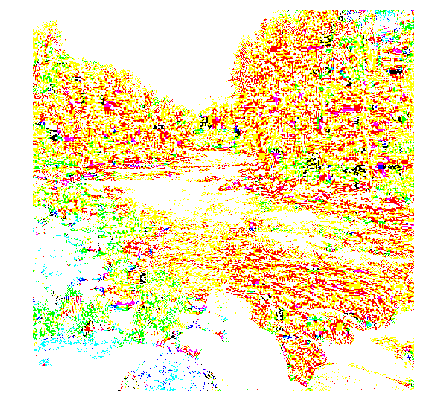

In [28]:
!ls output
implot(output_path+'out_20.jpg')